# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load data

In [2]:
df = pd.read_csv('vendor_aging.csv')

In [3]:
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

# Apply the preliminary functions
prepared_df = prepare_time_series_data(df)
metrics_df = calculate_aging_metrics_over_time(prepared_df)

print("Data prepared with basic metrics. Now analyzing trends...")

Data prepared with basic metrics. Now analyzing trends...


# Aging trends for each vendor over time

In [4]:

def calculate_aging_trends(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                          aging_cols=None, window=3):
    """
    Calculate aging trends for each vendor over time.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        aging_cols (list): List of aging bucket columns
        window (int): Window size for rolling calculations

    Returns:
        pandas.DataFrame: DataFrame with trend metrics for each vendor and snapshot
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Calculate metrics over time
    result_df = calculate_aging_metrics_over_time(df, snapshot_date_col, aging_cols, vendor_id_col)

    # Group by vendor and sort by date for time series operations
    vendor_groups = result_df.groupby(vendor_id_col)

    # Initialize columns for trends
    trend_cols = ['Balance_MoM_Change', 'Aging_Beyond_90_MoM_Change',
                 'Balance_Trend', 'Aging_Beyond_90_Trend']

    for col in trend_cols:
        result_df[col] = np.nan

    # Calculate trends for each vendor
    for vendor_id, group in vendor_groups:
        # Sort by snapshot date
        vendor_data = group.sort_values(snapshot_date_col)

        if len(vendor_data) >= 2:  # Need at least 2 snapshots for trend
            # Calculate month-over-month changes
            vendor_data['Balance_MoM_Change'] = vendor_data['Balance Outstanding'].pct_change() * 100
            vendor_data['Aging_Beyond_90_MoM_Change'] = vendor_data['Aging_Beyond_90'].pct_change() * 100

            # Calculate rolling average trend if enough data points
            if len(vendor_data) >= window:
                # Simple linear regression slope would be better, but for simplicity:
                vendor_data['Balance_Trend'] = vendor_data['Balance Outstanding'].rolling(window=window).apply(
                    lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100 if x.iloc[0] != 0 else 0
                )

                vendor_data['Aging_Beyond_90_Trend'] = vendor_data['Aging_Beyond_90'].rolling(window=window).apply(
                    lambda x: (x.iloc[-1] - x.iloc[0]) / (x.iloc[0] or 1) * 100
                )

            # Update the main dataframe with trend calculations
            result_df.loc[vendor_data.index, 'Balance_MoM_Change'] = vendor_data['Balance_MoM_Change']
            result_df.loc[vendor_data.index, 'Aging_Beyond_90_MoM_Change'] = vendor_data['Aging_Beyond_90_MoM_Change']
            result_df.loc[vendor_data.index, 'Balance_Trend'] = vendor_data['Balance_Trend']
            result_df.loc[vendor_data.index, 'Aging_Beyond_90_Trend'] = vendor_data['Aging_Beyond_90_Trend']

    # Categorize the trends
    result_df['Balance_Trend_Category'] = pd.cut(
        result_df['Balance_Trend'],
        bins=[-float('inf'), -10, -3, 3, 10, float('inf')],
        labels=['Rapidly Decreasing', 'Decreasing', 'Stable', 'Increasing', 'Rapidly Increasing']
    )

    result_df['Aging_Trend_Category'] = pd.cut(
        result_df['Aging_Beyond_90_Trend'],
        bins=[-float('inf'), -10, -3, 3, 10, float('inf')],
        labels=['Rapidly Improving', 'Improving', 'Stable', 'Worsening', 'Rapidly Worsening']
    )

    return result_df


In [5]:
trends_df = calculate_aging_trends(metrics_df)

In [6]:
print("\nColumns after calculating aging trends:")
trend_cols = ['Balance_MoM_Change', 'Aging_Beyond_90_MoM_Change', 
              'Balance_Trend', 'Aging_Beyond_90_Trend',
              'Balance_Trend_Category', 'Aging_Trend_Category']
print(trend_cols)


Columns after calculating aging trends:
['Balance_MoM_Change', 'Aging_Beyond_90_MoM_Change', 'Balance_Trend', 'Aging_Beyond_90_Trend', 'Balance_Trend_Category', 'Aging_Trend_Category']


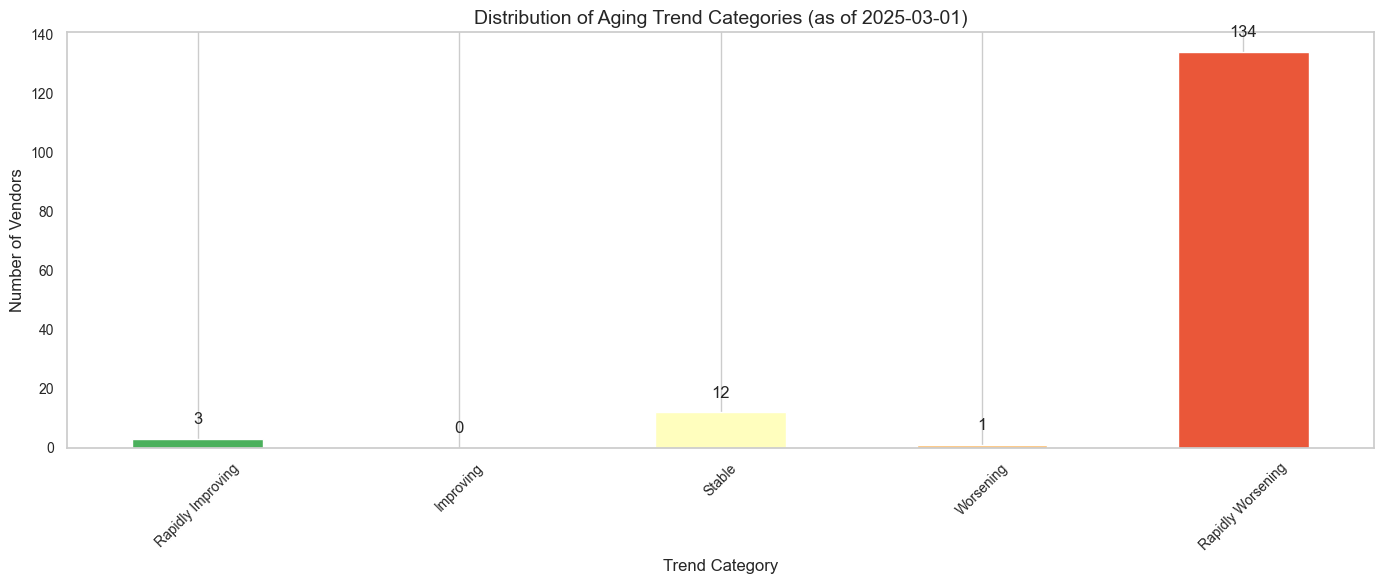

In [8]:
# Visualize the distribution of trend categories
latest_date = trends_df['Snapshot_Date'].max()
latest_trends = trends_df[trends_df['Snapshot_Date'] == latest_date]

plt.figure(figsize=(14, 6))
trend_counts = latest_trends['Aging_Trend_Category'].value_counts().sort_index()
ax = trend_counts.plot(kind='bar', color=sns.color_palette("RdYlGn_r", len(trend_counts)))
plt.title(f'Distribution of Aging Trend Categories (as of {latest_date.strftime("%Y-%m-%d")})')
plt.xlabel('Trend Category')
plt.ylabel('Number of Vendors')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Add count labels on top of bars
for i, v in enumerate(trend_counts):
    ax.text(i, v + 5, str(v), ha='center')

plt.show()

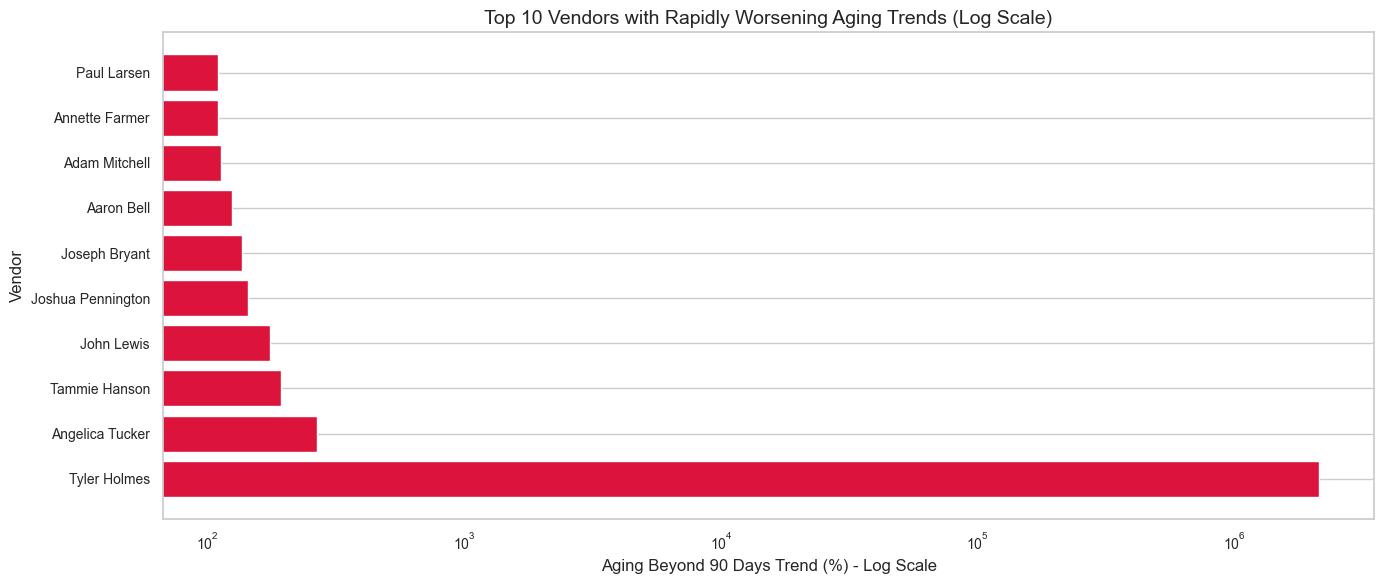

In [10]:
# Visualize vendors with rapidly worsening aging trends
worsening_vendors = latest_trends[latest_trends['Aging_Trend_Category'] == 'Rapidly Worsening'].sort_values(
    'Aging_Beyond_90_Trend', ascending=False).head(10)

plt.figure(figsize=(14, 6))
plt.barh(worsening_vendors['Vendor'], worsening_vendors['Aging_Beyond_90_Trend'], color='crimson')
plt.title('Top 10 Vendors with Rapidly Worsening Aging Trends (Log Scale)')
plt.xlabel('Aging Beyond 90 Days Trend (%) - Log Scale')
plt.ylabel('Vendor')
plt.grid(axis='x')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.tight_layout()
plt.show()


# Vendor payment history across snapshots

In [11]:

def vendor_payment_history_analysis(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                                  payment_date_col='LP Date', payment_amount_col='Vendor LP Amount'):
    """
    Analyze vendor payment history across snapshots.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        payment_date_col (str): Column containing last payment date
        payment_amount_col (str): Column containing last payment amount

    Returns:
        pandas.DataFrame: DataFrame with payment history metrics
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure date columns are datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    if not pd.api.types.is_datetime64_any_dtype(result_df[payment_date_col]):
        result_df[payment_date_col] = pd.to_datetime(result_df[payment_date_col], errors='coerce')

    # Calculate days between snapshot and last payment
    result_df['Days_Since_Payment'] = (result_df[snapshot_date_col] - result_df[payment_date_col]).dt.days

    # Group by vendor and extract payment history
    payment_history = []

    for vendor_id, group in result_df.groupby(vendor_id_col):
        vendor_history = group.sort_values(snapshot_date_col)

        # Track payment dates and amounts across snapshots
        payment_dates = vendor_history[payment_date_col].dropna().unique()
        payment_dates = sorted(payment_dates)

        # Calculate frequency metrics if we have multiple payments
        if len(payment_dates) >= 2:
            # Calculate average days between payments
            payment_intervals = [(payment_dates[i] - payment_dates[i-1]).days
                               for i in range(1, len(payment_dates))]
            avg_payment_interval = sum(payment_intervals) / len(payment_intervals)

            # Count payments in last 90 days (relative to each snapshot date)
            for idx, row in vendor_history.iterrows():
                snapshot_date = row[snapshot_date_col]
                payments_90d = sum(1 for date in payment_dates
                                  if snapshot_date - timedelta(days=90) <= date <= snapshot_date)

                result_df.loc[idx, 'Payments_Last_90d'] = payments_90d
                result_df.loc[idx, 'Avg_Payment_Interval_Days'] = avg_payment_interval
        else:
            # Only one payment date or none
            vendor_history_indexes = vendor_history.index
            result_df.loc[vendor_history_indexes, 'Payments_Last_90d'] = 0 if len(payment_dates) == 0 else 1
            result_df.loc[vendor_history_indexes, 'Avg_Payment_Interval_Days'] = np.nan

    # Calculate payment regularity score (higher is better)
    # Consider both frequency and consistency
    result_df['Payment_Regularity_Score'] = np.nan

    for vendor_id, group in result_df.groupby(vendor_id_col):
        if 'Avg_Payment_Interval_Days' in group.columns:
            avg_interval = group['Avg_Payment_Interval_Days'].iloc[0]
            if not pd.isna(avg_interval):
                # More regular = lower standard deviation in payment intervals
                # This is a placeholder calculation - in a real implementation,
                # you would use actual payment intervals
                regularity_score = 100 - min(100, avg_interval / 3)  # Higher score for shorter intervals
                result_df.loc[group.index, 'Payment_Regularity_Score'] = regularity_score

    return result_df

In [12]:
payment_df = vendor_payment_history_analysis(trends_df)

# Display the payment history columns
print("\nColumns after analyzing payment history:")
payment_cols = ['Days_Since_Payment', 'Payments_Last_90d', 
                'Avg_Payment_Interval_Days', 'Payment_Regularity_Score']
print(payment_cols)


Columns after analyzing payment history:
['Days_Since_Payment', 'Payments_Last_90d', 'Avg_Payment_Interval_Days', 'Payment_Regularity_Score']


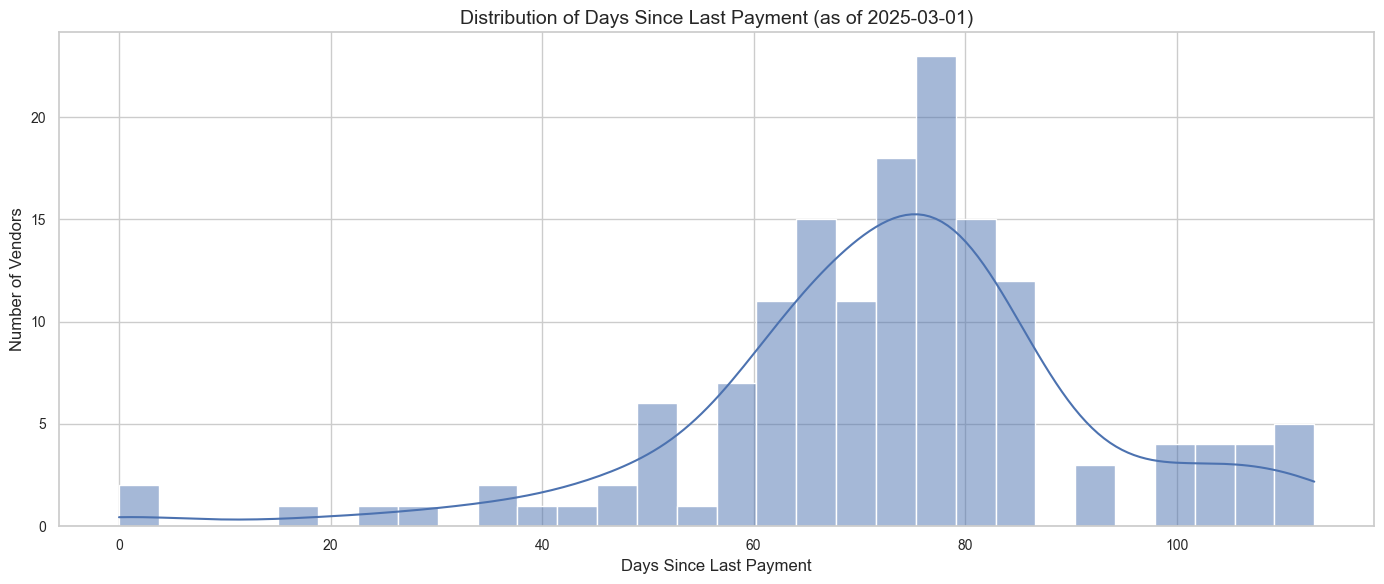

In [13]:
# Visualize days since last payment distribution
latest_date = payment_df['Snapshot_Date'].max()
latest_payment = payment_df[payment_df['Snapshot_Date'] == latest_date]

plt.figure(figsize=(14, 6))
sns.histplot(latest_payment['Days_Since_Payment'].dropna(), bins=30, kde=True)
plt.title(f'Distribution of Days Since Last Payment (as of {latest_date.strftime("%Y-%m-%d")})')
plt.xlabel('Days Since Last Payment')
plt.ylabel('Number of Vendors')
plt.grid(True)
plt.tight_layout()
plt.show()

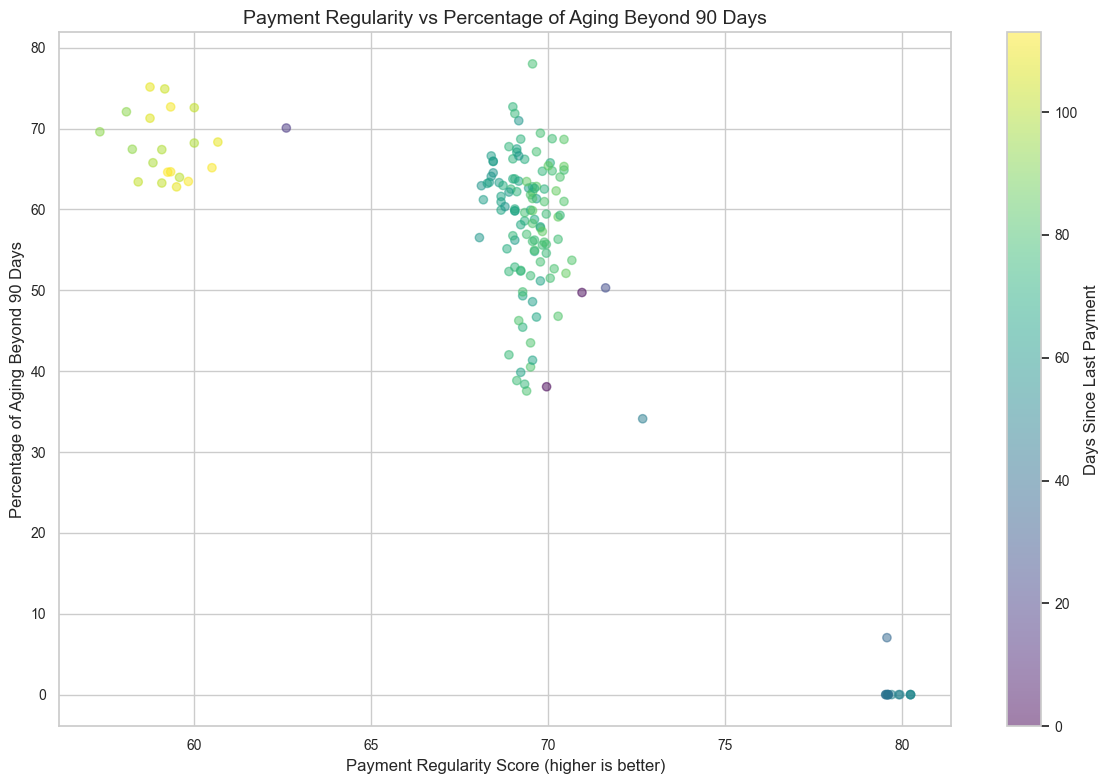

In [14]:
# Visualize payment regularity score vs aging beyond 90 days
plt.figure(figsize=(12, 8))
plt.scatter(latest_payment['Payment_Regularity_Score'], 
           latest_payment['Pct_Aging_Beyond_90'], 
           alpha=0.5, c=latest_payment['Days_Since_Payment'], cmap='viridis')
plt.colorbar(label='Days Since Last Payment')
plt.title('Payment Regularity vs Percentage of Aging Beyond 90 Days')
plt.xlabel('Payment Regularity Score (higher is better)')
plt.ylabel('Percentage of Aging Beyond 90 Days')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time based anomalies

In [ ]:
def detect_time_based_anomalies(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                              value_cols=None, zscore_threshold=5, window_size=12): # This function needs more work
    """
    Detect anomalies in vendor data based on time series patterns.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        value_cols (list): List of columns to check for anomalies
        zscore_threshold (float): Z-score threshold for flagging anomalies
        window_size (int): Size of the window for local anomaly detection

    Returns:
        pandas.DataFrame: DataFrame with time-based anomaly flags
    """
    # Define default value columns if not specified
    if value_cols is None:
        value_cols = [
            'Balance Outstanding', 
            'Aging_Beyond_90', 
            'Pct_Aging_Beyond_90',
            'Future_Aging',
            'Aging_0_30',
            'Aging_31_60',
            'Aging_61_90',
            'Aging_91_120',
            'Aging_121_180',
            'Aging_181_360',
            'Above_361_Aging'
        ]

    # Ensure we have time-based metrics
    if 'Aging_Beyond_90' not in df.columns:
        df = calculate_aging_metrics_over_time(df)

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize anomaly columns
    for col in value_cols:
        if col in result_df.columns:
            result_df[f'{col}_Anomaly'] = False
            result_df[f'{col}_Zscore'] = np.nan

    result_df['Time_Anomaly'] = False
    result_df['Anomaly_Details'] = ''

    # Detect anomalies for each vendor over time
    for vendor_id, group in result_df.groupby(vendor_id_col):
        if len(group) >= window_size:  # Need at least window_size data points
            vendor_data = group.sort_values(snapshot_date_col)
            
            for col in value_cols:
                if col in vendor_data.columns:
                    # First check: Look for sudden changes between consecutive points
                    if len(vendor_data) >= 2:
                        pct_changes = vendor_data[col].pct_change().abs()
                        # Flag large percentage changes (more than 100%)
                        large_changes = pct_changes > 1.0
                        
                        # Update anomalies based on large changes
                        for idx, is_change in zip(vendor_data.index[1:], large_changes[1:]):
                            if is_change:
                                result_df.loc[idx, f'{col}_Anomaly'] = True
                                result_df.loc[idx, f'{col}_Zscore'] = pct_changes.loc[idx]
                    
                    # Second check: Look for global outliers using z-score
                    mean_val = vendor_data[col].mean()
                    std_val = vendor_data[col].std()
                    
                    if std_val > 0:  # Avoid division by zero
                        zscores = np.abs((vendor_data[col] - mean_val) / std_val)
                        
                        # Flag global anomalies
                        global_anomalies = zscores > zscore_threshold
                        result_df.loc[vendor_data.index, f'{col}_Anomaly'] = (
                            result_df.loc[vendor_data.index, f'{col}_Anomaly'] | global_anomalies
                        )
                        
                        # Update z-scores (only if we haven't set them from pct_change)
                        for idx in vendor_data.index:
                            if pd.isna(result_df.loc[idx, f'{col}_Zscore']):
                                result_df.loc[idx, f'{col}_Zscore'] = zscores.loc[idx]
                    
                    # Third check: Look for local anomalies using rolling window
                    if len(vendor_data) >= window_size:
                        for i in range(window_size, len(vendor_data)):
                            window = vendor_data.iloc[i-window_size:i]
                            current_val = vendor_data.iloc[i][col]
                            
                            window_mean = window[col].mean()
                            window_std = window[col].std()
                            
                            if window_std > 0:
                                local_zscore = abs((current_val - window_mean) / window_std)
                                current_idx = vendor_data.index[i]
                                
                                # Flag if it's a local anomaly and not already flagged
                                if local_zscore > zscore_threshold and not result_df.loc[current_idx, f'{col}_Anomaly']:
                                    result_df.loc[current_idx, f'{col}_Anomaly'] = True
                                    result_df.loc[current_idx, f'{col}_Zscore'] = local_zscore

            # Combine anomalies across columns
            for idx, row in vendor_data.iterrows():
                anomaly_cols = []
                details = []
                
                for col in value_cols:
                    if col in vendor_data.columns:
                        anomaly_col = f'{col}_Anomaly'
                        zscore_col = f'{col}_Zscore'
                        
                        if anomaly_col in result_df.columns and result_df.loc[idx, anomaly_col]:
                            anomaly_cols.append(col)
                            
                            # Get direction
                            if vendor_data.index.get_loc(idx) > 0:
                                prev_idx = vendor_data.index[vendor_data.index.get_loc(idx) - 1]
                                direction = "increase" if row[col] > vendor_data.loc[prev_idx, col] else "decrease"
                            else:
                                direction = "abnormal value"
                                
                            z_val = result_df.loc[idx, zscore_col]
                            details.append(f"Unusual {direction} in {col} (score={z_val:.2f})")
                
                if anomaly_cols:
                    result_df.loc[idx, 'Time_Anomaly'] = True
                    result_df.loc[idx, 'Anomaly_Details'] = "; ".join(details)

    return result_df

In [49]:
anomalies_df = detect_time_based_anomalies(payment_df)

# Display the anomaly detection columns
print("\nColumns after detecting time-based anomalies:")
anomaly_cols = ['Balance Outstanding_Anomaly', 'Aging_Beyond_90_Anomaly', 
                'Pct_Aging_Beyond_90_Anomaly', 'Time_Anomaly']
print(anomaly_cols)


Columns after detecting time-based anomalies:
['Balance Outstanding_Anomaly', 'Aging_Beyond_90_Anomaly', 'Pct_Aging_Beyond_90_Anomaly', 'Time_Anomaly']


In [50]:
# Check how many anomalies were detected
latest_date = anomalies_df['Snapshot_Date'].max()
latest_anomalies = anomalies_df[anomalies_df['Snapshot_Date'] == latest_date]

print(f"\nNumber of vendors with time anomalies: {latest_anomalies['Time_Anomaly'].sum()}")
print(f"Percentage of vendors with anomalies: {latest_anomalies['Time_Anomaly'].mean()*100:.2f}%")


Number of vendors with time anomalies: 69
Percentage of vendors with anomalies: 46.00%


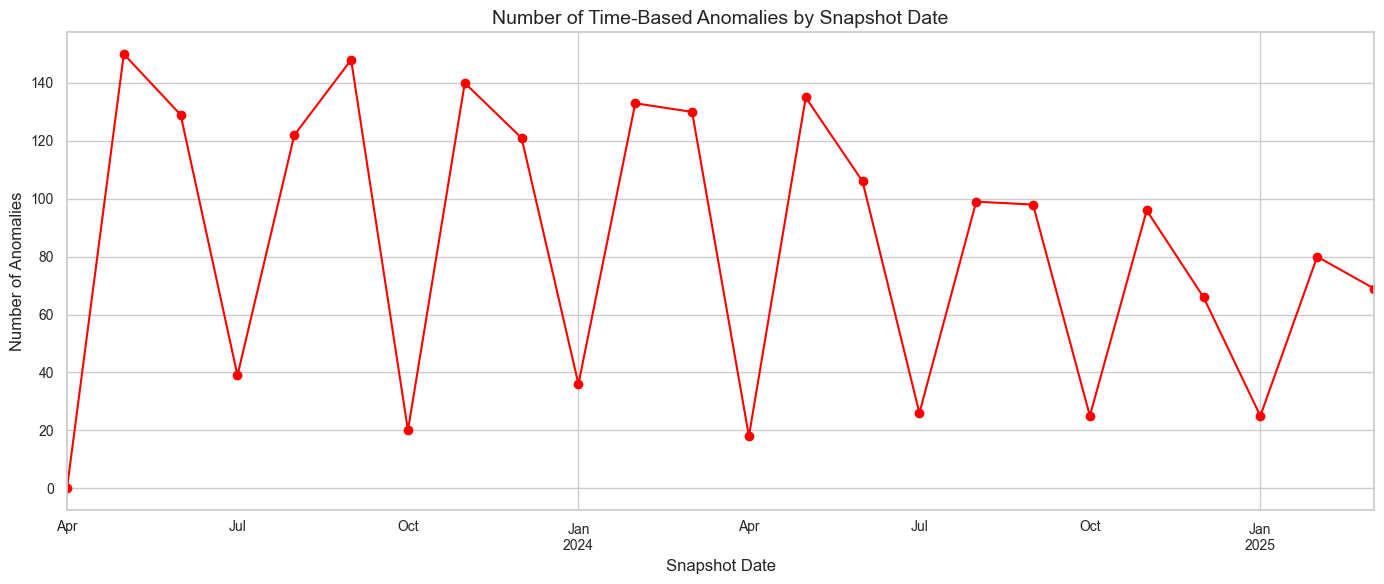

In [51]:
# Visualize anomalies over time
anomaly_count_by_date = anomalies_df.groupby('Snapshot_Date')['Time_Anomaly'].sum()

plt.figure(figsize=(14, 6))
anomaly_count_by_date.plot(marker='o', linestyle='-', color='red')
plt.title('Number of Time-Based Anomalies by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Anomalies')
plt.grid(True)
plt.tight_layout()
plt.show()


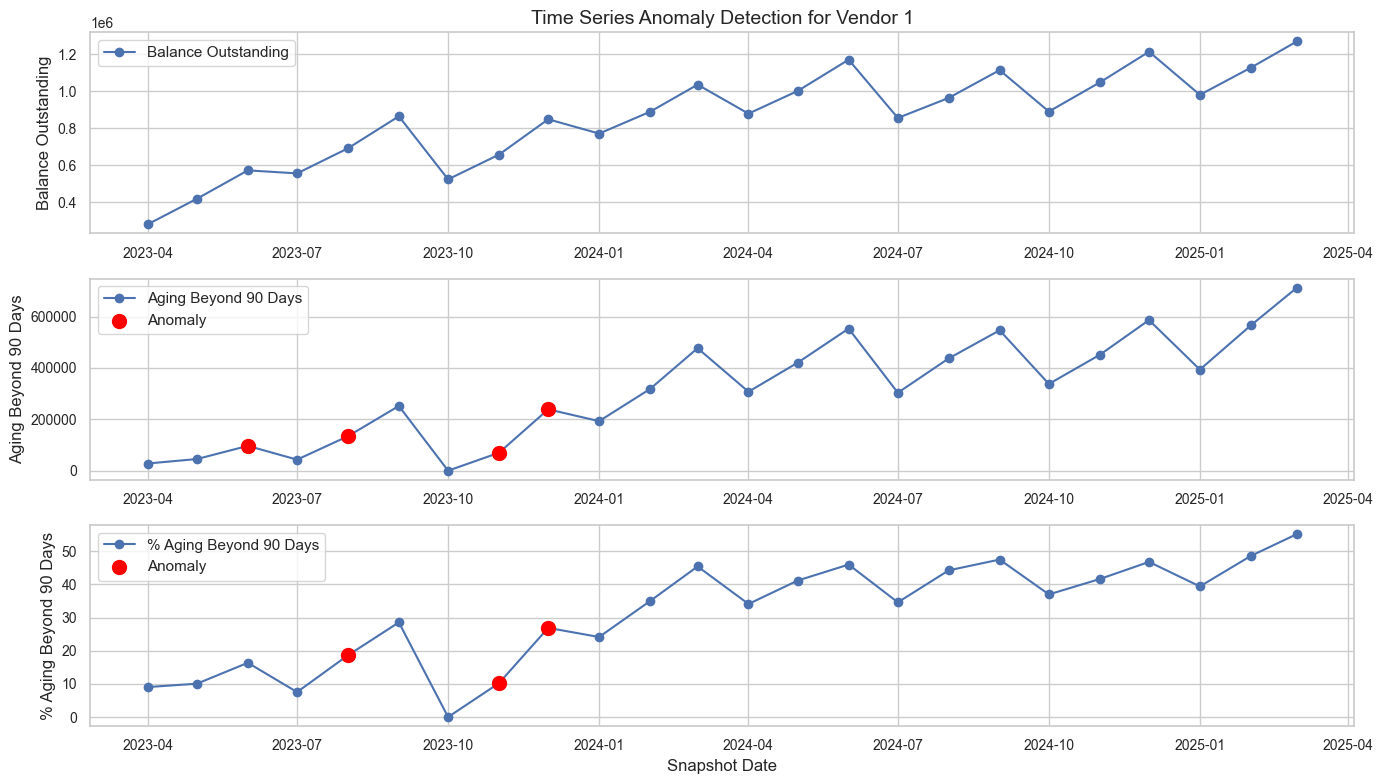

In [52]:
# Visualize an example of a vendor with anomalies
if latest_anomalies['Time_Anomaly'].sum() > 0:
    # Find a vendor with anomalies
    example_vendor_id = latest_anomalies[latest_anomalies['Time_Anomaly']].iloc[0]['Vendor ID']
    vendor_data = anomalies_df[anomalies_df['Vendor ID'] == example_vendor_id].sort_values('Snapshot_Date')
    
    plt.figure(figsize=(14, 8))
    
    # Plot balance outstanding and highlight anomalies
    ax = plt.subplot(3, 1, 1)
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Balance Outstanding'], marker='o', label='Balance Outstanding')
    # Highlight anomalies
    anomaly_points = vendor_data[vendor_data['Balance Outstanding_Anomaly']]
    if not anomaly_points.empty:
        plt.scatter(anomaly_points['Snapshot_Date'], anomaly_points['Balance Outstanding'], 
                   color='red', s=100, label='Anomaly', zorder=5)
    plt.title(f'Time Series Anomaly Detection for Vendor {example_vendor_id}')
    plt.ylabel('Balance Outstanding')
    plt.legend()
    plt.grid(True)
    
    # Plot aging beyond 90 days
    ax = plt.subplot(3, 1, 2)
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Aging_Beyond_90'], marker='o', label='Aging Beyond 90 Days')
    # Highlight anomalies
    anomaly_points = vendor_data[vendor_data['Aging_Beyond_90_Anomaly']]
    if not anomaly_points.empty:
        plt.scatter(anomaly_points['Snapshot_Date'], anomaly_points['Aging_Beyond_90'], 
                   color='red', s=100, label='Anomaly', zorder=5)
    plt.ylabel('Aging Beyond 90 Days')
    plt.legend()
    plt.grid(True)
    
    # Plot percentage of aging beyond 90 days
    ax = plt.subplot(3, 1, 3)
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Pct_Aging_Beyond_90'], marker='o', label='% Aging Beyond 90 Days')
    # Highlight anomalies
    anomaly_points = vendor_data[vendor_data['Pct_Aging_Beyond_90_Anomaly']]
    if not anomaly_points.empty:
        plt.scatter(anomaly_points['Snapshot_Date'], anomaly_points['Pct_Aging_Beyond_90'], 
                   color='red', s=100, label='Anomaly', zorder=5)
    plt.ylabel('% Aging Beyond 90 Days')
    plt.xlabel('Snapshot Date')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [53]:
if latest_anomalies['Time_Anomaly'].sum() > 0:
    anomaly_examples = latest_anomalies[latest_anomalies['Time_Anomaly']].head(5)
    print("\nExample anomaly details:")
    for i, (_, row) in enumerate(anomaly_examples.iterrows()):
        print(f"{i+1}. Vendor {row['Vendor ID']} - {row['Vendor']}:")
        print(f"   {row['Anomaly_Details']}")
        print(f"   Balance: ${row['Balance Outstanding']:,.2f}, Aging Beyond 90: ${row['Aging_Beyond_90']:,.2f} ({row['Pct_Aging_Beyond_90']:.2f}%)")
        print()


Example anomaly details:
1. Vendor 1 - Lisa Hensley:
   Unusual increase in Above_361_Aging (score=11.47)
   Balance: $1,269,546.59, Aging Beyond 90: $712,022.99 (55.13%)

2. Vendor 4 - Maria Lynch:
   Unusual increase in Above_361_Aging (score=inf)
   Balance: $816,526.19, Aging Beyond 90: $438,571.10 (52.37%)

3. Vendor 5 - James Mayo:
   Unusual increase in Above_361_Aging (score=1.40)
   Balance: $108,635.23, Aging Beyond 90: $61,909.00 (56.21%)

4. Vendor 7 - Latoya Robbins:
   Unusual increase in Above_361_Aging (score=1.80)
   Balance: $4,667,921.91, Aging Beyond 90: $2,602,097.38 (54.59%)

5. Vendor 12 - Juan Dunlap:
   Unusual increase in Above_361_Aging (score=2.94)
   Balance: $155,396.71, Aging Beyond 90: $88,168.84 (56.06%)



In [54]:
print("\n" + "="*80)
print("SUMMARY OF TREND ANALYSIS FUNCTIONS")
print("="*80)
print("\n1. calculate_aging_trends:")
print("   - Calculates month-over-month changes in balance and aging")
print("   - Computes rolling window trends to detect momentum")
print("   - Categorizes trends into descriptive categories (e.g., 'Rapidly Worsening')")
print("   - Helps identify vendors with concerning directional movements")

print("\n2. vendor_payment_history_analysis:")
print("   - Analyzes payment patterns and consistency")
print("   - Calculates days since last payment and payment frequency")
print("   - Creates a payment regularity score to flag inconsistent payers")
print("   - Important for predicting future payment behavior")

print("\n3. detect_time_based_anomalies:")
print("   - Identifies unusual changes in key metrics compared to vendor's own history")
print("   - Uses statistical z-scores to flag significant deviations")
print("   - Provides detailed anomaly descriptions")
print("   - Critical for early detection of potential issues")

print("\nThese three functions work together to understand how vendors are trending over time,")
print("enabling proactive management before problems become severe. They form the foundation")
print("for both diagnostic and prescriptive analytics by identifying which vendors require")
print("immediate attention and what specific issues need to be addressed.")


SUMMARY OF TREND ANALYSIS FUNCTIONS

1. calculate_aging_trends:
   - Calculates month-over-month changes in balance and aging
   - Computes rolling window trends to detect momentum
   - Categorizes trends into descriptive categories (e.g., 'Rapidly Worsening')
   - Helps identify vendors with concerning directional movements

2. vendor_payment_history_analysis:
   - Analyzes payment patterns and consistency
   - Calculates days since last payment and payment frequency
   - Creates a payment regularity score to flag inconsistent payers
   - Important for predicting future payment behavior

3. detect_time_based_anomalies:
   - Identifies unusual changes in key metrics compared to vendor's own history
   - Uses statistical z-scores to flag significant deviations
   - Provides detailed anomaly descriptions
   - Critical for early detection of potential issues

These three functions work together to understand how vendors are trending over time,
enabling proactive management before problem